In [1]:
from qiskit import __version__
print(__version__)

1.4.2


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit.library import HGate, UnitaryGate

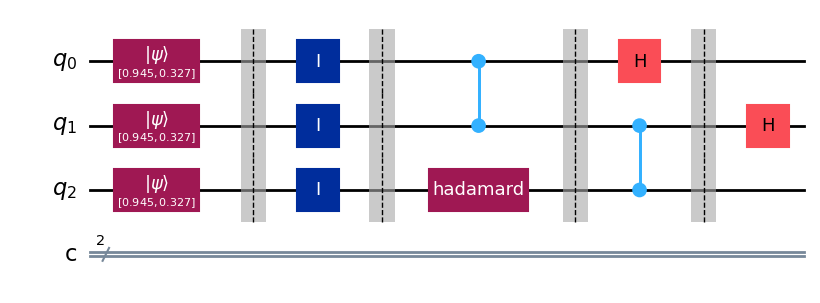

In [3]:
# Create a UnitaryGate with Hadamard matrix but custom label
H_matrix = HGate().to_matrix()
h_tagged = UnitaryGate(H_matrix, label='hadamard')

circuit = QuantumCircuit(3, 2)

# State prep
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

for i in range(3):
    circuit.initialize([amp_0, amp_1], i)
circuit.barrier()

# Insert errors right after state prep
for a in range(3):
    circuit.id(a)
circuit.barrier()

# CZ on qubits 0,1 and Hadamard on qubit 2
circuit.cz(0,1)
circuit.append(h_tagged, [2])
circuit.barrier()
    
# Measure qubit 0 in X basis, and CZ on qubits 1,2 
circuit.h(0)
circuit.cz(1,2)
circuit.barrier()

# Measure qubit 1 in X basis, and insert error on qubit 2
circuit.h(1)

display(circuit.draw(output='mpl'))

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='4c4fc663-79cd-418d-bf35-b9b7debd6337', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 208, '0x3': 93, '0x0': 399, '0x2': 300}, state_post={'0x1': [Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.08141176+4.45959483e-16j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2)), Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.08141176+4.45959483e-16j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2)), Statevector([0.        +0.00000000e+00j, 0.99668055+1.35325636e-15j,
             0.

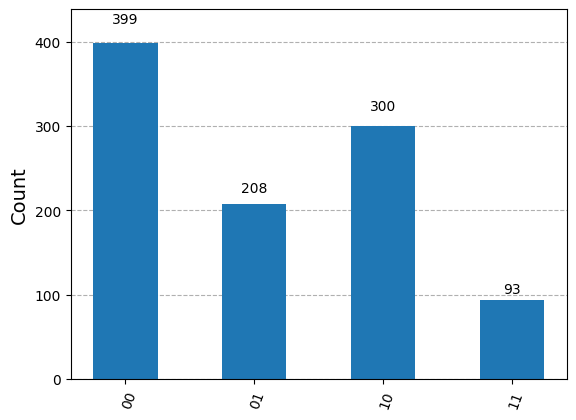

In [13]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,1), ['h_targeted'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2),['cz'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.95, 0.05],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.05, 0.95]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [0])
noise_model.add_readout_error(readout_err, [1])


meas_circuit_noise = circuit.copy()
meas_circuit_noise.measure([0, 1], [0, 1])

meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

backend = AerSimulator(noise_model=noise_model)

transpiled = transpile(meas_circuit_noise, backend)

job = backend.run(transpiled,shots=1000)
result = job.result()
print(result)

counts_noise = result.get_counts()
display(plot_histogram(counts_noise)) 

In [14]:
res_statevectors = result.data()['state_post']

target_amplitudes = Statevector([
    0.94502682+1.41221240e-15j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
             0.32699283+5.19195734e-16j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2))

correct = 0
for value in res_statevectors['0x0']:
    if target_amplitudes == value:
        correct += 1
meas00 = len(res_statevectors['0x0']) 

print(f"Number of correct outputs measuring '00': {correct}")
print(f"Number of outputs measuring '00: {meas00}")

Number of correct outputs measuring '00': 354
Number of outputs measuring '00: 399


In [15]:
# Calculating the average state of all 00 measurement outcomes
average = np.zeros(8, dtype=complex)

for shot in res_statevectors['0x0']:
    average += shot.data
    
average /= np.linalg.norm(average)
average_state = Statevector(average)
#display(average_state.draw("latex"))


ideal = Statevector([0.94502682+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.32699283+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))
#display(ideal.draw("latex"))

fidelity = state_fidelity(ideal, average_state)
print(fidelity)

0.9982397141316506


# Keeping the Readout Error constant but changing the depolarizing noise

In [21]:
depol_probs = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2] 
fidelity_results = {}

for p in depol_probs:
    # New noise model for each depolarizing probability
    noise_model = NoiseModel()

    # Apply depolarizing error with probability p
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['id', 'h_targeted'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 2), ['cz']) 

    # Keep readout error constant
    noise_model.add_readout_error(readout_err, [0])
    noise_model.add_readout_error(readout_err, [1])
    
    # A copy of the circuit
    meas_circuit_noise = circuit.copy()
    meas_circuit_noise.measure([0, 1], [0, 1]) 
    meas_circuit_noise.save_statevector(label='state_post', pershot=True, conditional=True)

    # Run simulation
    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(meas_circuit_noise, backend)
    job = backend.run(transpiled, shots=1000)
    result = job.result()
    
    # Extract final state and compute fidelity (modify as needed)
    res_statevectors = result.data()['state_post']
    average = np.zeros(8, dtype=complex)
    for shot in res_statevectors['0x0']:
        average += shot.data
        
    average /= np.linalg.norm(average)
    average_state = Statevector(average)
    
    fid = state_fidelity(average_state, ideal)  # assume you define this somewhere
    
    fidelity_results[p] = fid

In [22]:
print(fidelity_results)

{0.0: 0.9984691837868294, 0.02: 0.9981461184134205, 0.04: 0.9990517918851035, 0.06: 0.9978389489823603, 0.08: 0.9978106067354485, 0.1: 0.9987358508672933, 0.12: 0.9982827228723856, 0.14: 0.99847713308199, 0.16: 0.9993269326075477, 0.18: 0.998395774225046, 0.2: 0.9971836869426035}


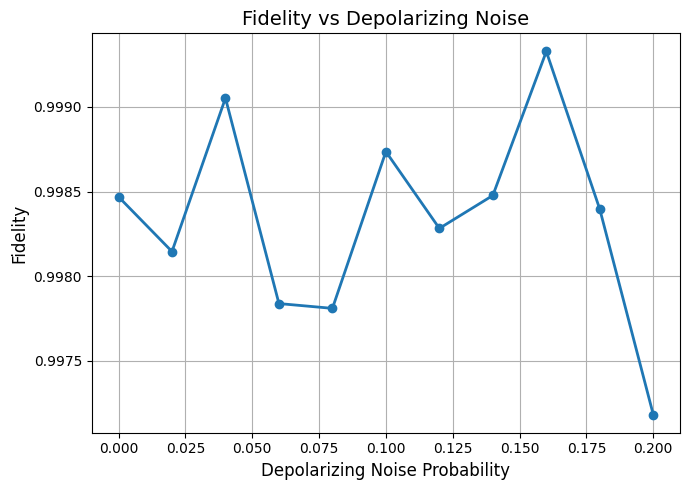

In [23]:
import matplotlib.pyplot as plt

# Ensure values are sorted by noise level
depol_probs = sorted(fidelity_results.keys())
fidelities = [fidelity_results[p] for p in depol_probs]

plt.figure(figsize=(7, 5))
plt.plot(depol_probs, fidelities, marker='o', linewidth=2)
plt.xlabel("Depolarizing Noise Probability", fontsize=12)
plt.ylabel("Fidelity", fontsize=12)
plt.title("Fidelity vs Depolarizing Noise", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()